## Learning Full Covariance Example Notebook
by Jack Barry

NOTE: model paths will be diffrent for you, so be sure to correct them before running this script

Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load sample data and make sure all datasets have the same number of samples. You can replace this data with anything you want as long as it follows the same format.

In this case X is a set of initial conditions for an exponentially decaying function Y1, and Y2 is a piecewise function equal to Y1 for the first half of the interval and equal to -Y1 for the second half. This should result in a distinct corralation.

In [6]:
X_path = "/home/gjc7gx/CovNNet/Example/X_sample.txt" 
Y1_path = "/home/gjc7gx/CovNNet/Example/Y1_sample.txt"
Y2_path = "/home/gjc7gx/CovNNet/Example/Y2_sample.txt"

X = np.loadtxt(X_path)
Y1 = np.loadtxt(Y1_path)
Y2 = np.loadtxt(Y2_path)

assert len(X) == len(Y1) == len(Y2), "Mismatch in number of samples." 

Y = np.column_stack((Y1, Y2)) # combine Y1 and Y2

X_len = X.shape[1]
Y1_len = Y1.shape[1]
Y2_len = Y2.shape[1]
Y_len = Y.shape[1]

Create Dataset

In [7]:
class ParamDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [8]:
# train-validation-test split
train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

dataset = ParamDataset(X, Y)
n_total = len(dataset)
n_train = int(train_size * n_total)
n_valid = int(valid_size * n_total)
n_test  = n_total - n_train - n_valid

# use fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
print("Creating dataset with seed " + str(seed) + "...")
generator = torch.Generator().manual_seed(seed)
train_data, valid_data, test_data = random_split(dataset, [n_train, n_valid, n_test], generator=generator)

# create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)
print("Done")

Creating dataset with seed 42...
Done


Define Hyperparameters

In [9]:
MODEL_DIR  = "/home/gjc7gx/CovNNet/Example/" # define path to save best model
MODEL_NAME = f"example"
CKPT_PATH  = os.path.join(MODEL_DIR, MODEL_NAME + ".pt")

cov_hc       = 64    # hidden width for learning covariance 
cov_nl       = 2     # hidden layers
mean_hc       = 200   # hidden width for learning mean
mean_nl       = 3     # hidden layers
wd       = 1e-5     # weight decay
n_epochs = 1000     # number of training epochs (from personal experiance I find I need to train for longer than I think)

# Def model input and output dim
X_len = X.shape[1]
Y1_len = Y1.shape[1]
Y2_len = Y2.shape[1]
Y_len = Y.shape[1]

model classes and creation functions. One model predicts dataset mean while the other predicts covariance.

In [10]:
class MeanMLP(nn.Module):
    """
    Class for the MLP that learns the dataset mean
    """
    def __init__(self, in_dim: int, out_dim: int, hidden: int = 256, n_layers: int = 3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(n_layers):
            layers += [nn.Linear(last, hidden), nn.ReLU()]
            last = hidden
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):  # [batch_size, in_dim]
        return self.net(x) # [batch_size, out_dim]


class CovarianceMLP(nn.Module):
    """
    Class for the MLP that learns the dataset covariance (specifically learns Cholesky matrix L)
    """
    def __init__(self, in_dim, out_dim, hidden=256, n_layers=3,
                min_std=5e-5, max_std=None, off_cap=0.3, off_warmup_scale=1.0,
                diag_temp=0.8):
        """
        Training stability variables:
        min_std, max_std: min-max std for L diagonal
        off_cap: caps off diagonal elements of L
        off_warmup_scale: modifies how quickly off diagonal elements of L are introduced (1: full strength from the start. <1: growing contributions)
        diag_temp: scales how L diagonals grow (<1: more sensitive. >1: less sensitive)
        """
        super().__init__()
        self.dy = out_dim
        self.min_std = float(min_std)
        self.max_std = None if max_std is None else float(max_std)
        self.off_cap = float(off_cap)
        self.register_buffer("off_warmup_scale", torch.tensor(float(off_warmup_scale)))
        self.diag_temp = float(diag_temp)

        m = out_dim * (out_dim + 1) // 2
        layers, last = [], in_dim
        for _ in range(n_layers):
            layers += [nn.Linear(last, hidden), nn.ReLU()]
            last = hidden
        self.net = nn.Sequential(*layers, nn.Linear(last, m))

        rows, cols = torch.tril_indices(out_dim, out_dim, 0)
        diag_mask = rows == cols
        self.register_buffer("rows", rows)
        self.register_buffer("cols", cols)
        self.register_buffer("diag_mask", diag_mask)
        self.register_buffer("off_mask", ~diag_mask)

        # init around a moderate std (~0.1)
        target_std = 0.1
        for mod in self.modules():
            if isinstance(mod, nn.Linear):
                nn.init.kaiming_uniform_(mod.weight, a=math.sqrt(5))
                if mod.bias is not None:
                    nn.init.zeros_(mod.bias)
        with torch.no_grad():
            bias = self.net[-1].bias
            # raw diag centered so softplus(raw/diag_temp) ≈ target_std - min_std
            target_raw = math.log(math.expm1(max(target_std - self.min_std, 1e-6)))
            bias[self.diag_mask] = target_raw * self.diag_temp

    def forward(self, x): # [batch_size, in_dim]
        B, d = x.shape[0], self.dy
        params = self.net(x)
        raw_diag = params[:, self.diag_mask]                 # [batch_size, out_dim] (diagonal elements of L)
        raw_off  = params[:, self.off_mask]                  # [batch size, out_dim(out_dim−1)/2] (lower-triangular elements of L)

        # constructing diagonal of L
        diag = self.min_std + F.softplus(raw_diag / self.diag_temp) # softplus for stability
        if self.max_std is not None:
            diag = torch.clamp(diag, max=self.max_std)

        # construct off diagonals of L
        off  = torch.tanh(raw_off) * self.off_cap * float(self.off_warmup_scale.item())

        # assemble full lower triangular matrix
        L_off = x.new_zeros(B, d, d) # [batch size, out_dim, out_dim]
        L_off[:, self.rows[self.off_mask], self.cols[self.off_mask]] = off
        L = L_off + torch.diag_embed(diag)
        return L


class CovWithTemp(nn.Module):
    """
    Wrapper for CovarianceMLP that allows the model to rescale covariance during training (Not nessicary but useful. multiplies L * tau)
    """
    def __init__(self, cov_head):
        super().__init__()
        self.cov_head = cov_head
        self.log_tau = nn.Parameter(torch.zeros(()))  # initialize tau at 1

    def forward(self, x):
        L = self.cov_head(x)
        tau = torch.exp(self.log_tau) # scale L
        return L * tau


def make_models(in_dim, out_dim, cov_hc=64, mean_hc=64, cov_nl=2, mean_nl=3):
    """
    Function to create models and define the loss function
    """
    loss_fn = gaussian_nll

    mean_net = MeanMLP(in_dim, out_dim, hidden=mean_hc, n_layers=mean_nl).to(device)
    base_cov = CovarianceMLP(in_dim=X_len, out_dim=Y_len, hidden=cov_hc, n_layers=cov_nl).to(device)
    cov_net  = CovWithTemp(base_cov).to(device)

    return mean_net, cov_net, loss_fn


Define loss function.

In [ ]:
# define loss function
def gaussian_nll(mu, L, y, cov_weight=1.0, lambda_off=1e-3):
    """
    Loss function as described in Learning_full_covariance.pdf

    mu: [batch_size, out_dim],  predicted mean
    L: [batch size, out_dim, out_dim] predicted covariance (Cholesky matrix)
    y: [batch_size, out_dim], true values
    cov_weight: scales how much covariance is weighted vs mean
    lambda_off: off diagonal penelties on L
    """

    # compute terms inside the brackets
    diff = (y - mu).unsqueeze(-1) # true vs pred
    z = torch.linalg.solve_triangular(L, diff, upper=False) # z = L^-1 (y - mu)
    maha   = (z.square()).sum(dim=(1,2)) # compute Mahalanobis distance: maha = z^T z = (y-mu)^T L^-T L^-1 (y-mu) where Sigma = LL^T >> maha = (y-mu)^T Sigma^-1 (y-mu)
    logdet = 2.0 * torch.log(torch.diagonal(L, dim1=1, dim2=2)).sum(dim=1) # compute log det term
    dconst = L.size(-1) * math.log(2.0 * math.pi) # compute constant (+ dy/2 log(2pi) term in PDF but multiplied by 2 so it could go inside the brackets)

    # distribute *1/2
    mean_term = 0.5 * maha # gives a sense of mean loss
    cov_term  = 0.5 * (logdet + dconst) # gives a sense of covariance loss

    # not included in Learning_full_covariance.pdf but added here for training stability
    diag = torch.diagonal(L, dim1=1, dim2=2)
    off  = L - torch.diag_embed(diag)
    off_pen = off.pow(2).mean(dim=(1,2))  # encourage small off-diagonals early

    total = mean_term + cov_weight * cov_term + lambda_off * off_pen
    return total.mean(), mean_term.mean(), cov_term.mean()

define model training and evaluation functions 

In [12]:

@torch.no_grad()
def eval_epoch(mean_net, cov_net, loss_fn, loader):
    mean_net.eval(); cov_net.eval()
    tot_sum = mean_sum = cov_sum = 0.0
    count = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        mu = mean_net(xb)
        L  = cov_net(xb)
        B  = xb.size(0)
        total_loss, mean_loss, cov_loss = loss_fn(mu, L, yb)

        tot_sum  += total_loss.item() * B
        mean_sum += mean_loss.item()  * B
        cov_sum  += cov_loss.item()   * B
        count    += B

    avg_total = tot_sum / max(1, count)
    avg_mean  = mean_sum / max(1, count)
    avg_cov   = cov_sum  / max(1, count)
    return avg_total, avg_mean, avg_cov


def train_one_epoch(mean_net, cov_net, loss_fn, loader, opt, max_grad_norm=1.0):
    mean_net.train(); cov_net.train()
    tot_sum = mean_sum = cov_sum = 0.0
    count = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        mask = torch.isfinite(yb).all(dim=1)
        if mask.sum() == 0:
            continue
        xb, yb = xb[mask], yb[mask]

        mu = mean_net(xb)
        L  = cov_net(xb)

        B  = xb.size(0)
        
        total_loss, mean_loss, cov_loss = loss_fn(mu, L, yb)

        opt.zero_grad(set_to_none=True)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(list(mean_net.parameters()) + list(cov_net.parameters()),
                                    max_norm=max_grad_norm)
        opt.step()

        tot_sum  += total_loss.item() * B
        mean_sum += mean_loss.item()  * B
        cov_sum  += cov_loss.item()   * B
        count    += B

    avg_total = tot_sum / max(1, count)
    avg_mean  = mean_sum / max(1, count)
    avg_cov   = cov_sum  / max(1, count)
    return avg_total, avg_mean, avg_cov


Create models and train

In [ ]:
# create models
mean_net, cov_net, loss_fn = make_models(
    in_dim=X.shape[1], out_dim=Y_len, cov_hc=cov_hc, cov_nl=cov_nl, mean_hc=mean_hc, mean_nl=mean_nl
)

# set learning rates for mean and covariance nets
optimizer = optim.Adam([
    {'params': mean_net.parameters(), 'lr': 1e-5},    
    {'params': cov_net.parameters(), 'lr': 1e-5},
], weight_decay=wd)


print(f"Training (full covariance) with output dim = {Y_len} and m = {Y_len*(Y_len+1)//2} tril params")
best_val = float("inf")
best_state = None

for epoch in range(1, n_epochs + 1):
    tr_total, tr_mean, tr_cov = train_one_epoch(mean_net, cov_net, loss_fn, train_loader, optimizer)
    va_total, va_mean, va_cov = eval_epoch(mean_net, cov_net, loss_fn, valid_loader)

    if epoch % 10 == 0 or epoch == 1 or va_total < best_val:

        if va_total < best_val:
            print(f"Epoch {epoch:04d} | Train: {tr_total:.6f} | mean: {tr_mean:.6f} | cov: {tr_cov:.6f} | "
                f"Val: {va_total:.6f} | mean: {va_mean:.6f} | cov: {va_cov:.6f} (B)")
            best_val = va_total
            best_state = (mean_net.state_dict(), cov_net.state_dict())
            torch.save(
                        {
                            "mean_state_dict": best_state[0],
                            "cov_state_dict": best_state[1],
                            "X_len": X_len,
                            "Y_len": Y_len,
                        }, CKPT_PATH) # save best

            mean_net.load_state_dict(best_state[0]) # load best
            cov_net.load_state_dict(best_state[1])

        else:
            print(f"Epoch {epoch:04d} | Train: {tr_total:.6f} | mean: {tr_mean:.6f} | cov: {tr_cov:.6f} | "
                f"Val: {va_total:.6f} | mean: {va_mean:.6f} | cov: {va_cov:.6f}")


Training (full covariance) with output dim = 20 and m = 210 tril params
Epoch 0001 | Train: 915.895393 | mean: 943.731077 | cov: -27.835672 | Val: 710.873240 | mean: 738.665603 | cov: -27.792379 (B)
Epoch 0002 | Train: 718.535322 | mean: 746.310410 | cov: -27.775087 | Val: 560.447495 | mean: 588.182920 | cov: -27.735403 (B)
Epoch 0003 | Train: 572.095154 | mean: 599.811647 | cov: -27.716496 | Val: 450.973420 | mean: 478.654297 | cov: -27.680874 (B)
Epoch 0004 | Train: 465.423340 | mean: 493.081803 | cov: -27.658460 | Val: 367.014797 | mean: 394.640997 | cov: -27.626187 (B)
Epoch 0005 | Train: 380.462764 | mean: 408.064478 | cov: -27.601714 | Val: 300.991982 | mean: 328.564055 | cov: -27.572077 (B)
Epoch 0006 | Train: 313.107080 | mean: 340.650815 | cov: -27.543742 | Val: 247.053763 | mean: 274.570851 | cov: -27.517093 (B)
Epoch 0007 | Train: 257.273679 | mean: 284.761334 | cov: -27.487651 | Val: 203.081126 | mean: 230.546979 | cov: -27.465843 (B)
Epoch 0008 | Train: 212.458956 | mean: 

Load best model

In [14]:
mean_net, cov_net, loss_fn = make_models(
    in_dim=X_len,
    out_dim=Y_len,
    cov_hc=cov_hc,
    cov_nl=cov_nl,
    mean_hc=mean_hc,
    mean_nl=mean_nl,
)

checkpoint = torch.load(CKPT_PATH, map_location=device)

mean_net.load_state_dict(checkpoint["mean_state_dict"])
cov_net.load_state_dict(checkpoint["cov_state_dict"])

mean_net.to(device).eval()
cov_net.to(device).eval()

print(f"Loaded best model from {CKPT_PATH}")

Loaded best model from /home/gjc7gx/CovNNet/Example/example.pt


/tmp/ipykernel_543196/1384222125.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH, map_location=device)


Plot results. they should look like the results shown in the figure true_corr_blocks.png.

In [ ]:
@torch.no_grad()
def plot_one_simulation_with_bands_and_corr_blocks(
    mean_net,
    cov_net,
    x,          # [in_dim]
    y_true,     # [2*out_dim] (2* because Y1 and Y2)
    r_tags,     # [out_dim] radius values 
    device,
    Y1_len=50,
    ci_sigma=2.0 # how wide of an uncertanty band to show
):

    # forward pass
    x = x.to(device).float().unsqueeze(0) 
    y_true = y_true.detach().cpu().numpy()

    mean_net.eval()
    cov_net.eval()

    mu = mean_net(x) # [batch_size, out_dim],  predicted mean
    L  = cov_net(x) # [batch size, out_dim, out_dim] predicted covariance (Cholesky matrix)
    Sigma = L @ L.transpose(1, 2) # create Cholesky-based parameterization

    mu = mu.squeeze(0).cpu().numpy()            
    Sigma = Sigma.squeeze(0).cpu().numpy() 

    d_out = mu.shape[0]
    Y2_len = d_out - Y1_len

    # split into Y1, Y2
    mu1 = mu[:Y1_len] # Y1 mean
    mu2 = mu[Y1_len:] # Y2 mean
    y1  = y_true[:Y1_len]
    y2  = y_true[Y1_len:]

    # create sigma bands
    std = np.sqrt(np.clip(np.diag(Sigma), 0.0, None)) # pull stev from diag of Sigma
    std1 = std[:Y1_len] # Y1 stdev
    std2 = std[Y1_len:] # Y2 stdev

    # Y1 and Y2 upper and lower bounds
    lower1 = mu1 - ci_sigma * std1
    upper1 = mu1 + ci_sigma * std1
    lower2 = mu2 - ci_sigma * std2
    upper2 = mu2 + ci_sigma * std2

    # create correlation matrix and blocks
    denom = np.sqrt(np.clip(np.diag(Sigma), 1e-12, None)) # avoid div by zero error w/ 1e-12
    Corr = Sigma / (denom[:, None] * denom[None, :] + 1e-12) # corr_ij = Sigma_ij / stdev_i * stdev_j

    C11 = Corr[:Y1_len, :Y1_len] # Y1Y1 corr
    C12 = Corr[:Y1_len, Y1_len:] # Y1Y2 corr
    C22 = Corr[Y1_len:, Y1_len:] # Y2Y2 corr

    # apply radius
    r = np.asarray(r_tags, dtype=float)
    r2 = r[:Y2_len]

    # create plots
    fig = plt.figure(figsize=(12, 8))
    outer = fig.add_gridspec(2, 1, height_ratios=[1.0, 1.5], hspace=0.35)

    top = outer[0].subgridspec(1, 2, wspace=0.3)
    ax1 = fig.add_subplot(top[0, 0])
    ax2 = fig.add_subplot(top[0, 1])

    ax1.plot(r, y1,  label="True Y1")
    ax1.plot(r, mu1, label="Mean Y1")
    ax1.fill_between(r, lower1, upper1, alpha=0.3, label=f"±{ci_sigma}σ")
    ax1.set_xlabel("Radius [kpc]")
    ax1.set_ylabel("Y1")
    ax1.legend()

    ax2.plot(r2, y2,  label="True Y2")
    ax2.plot(r2, mu2, label="Mean Y2")
    ax2.fill_between(r2, lower2, upper2, alpha=0.3, label=f"±{ci_sigma}σ")
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel("Y2")
    ax2.legend()

    bot = outer[1].subgridspec(1, 3, wspace=0.3)
    ax11 = fig.add_subplot(bot[0, 0])
    ax12 = fig.add_subplot(bot[0, 1])
    ax13 = fig.add_subplot(bot[0, 2])

    im1 = ax11.imshow(C11, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im2 = ax12.imshow(C12, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im3 = ax13.imshow(C22, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")

    ax11.set_title("Corr(Y1,Y1)")
    ax12.set_title("Corr(Y1,Y2)")
    ax13.set_title("Corr(Y2,Y2)")

    ax11.invert_yaxis()
    ax12.invert_yaxis()
    ax13.invert_yaxis()


    fig.colorbar(im3, ax=[ax11, ax12, ax13], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    return fig


/tmp/ipykernel_543196/1994346243.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


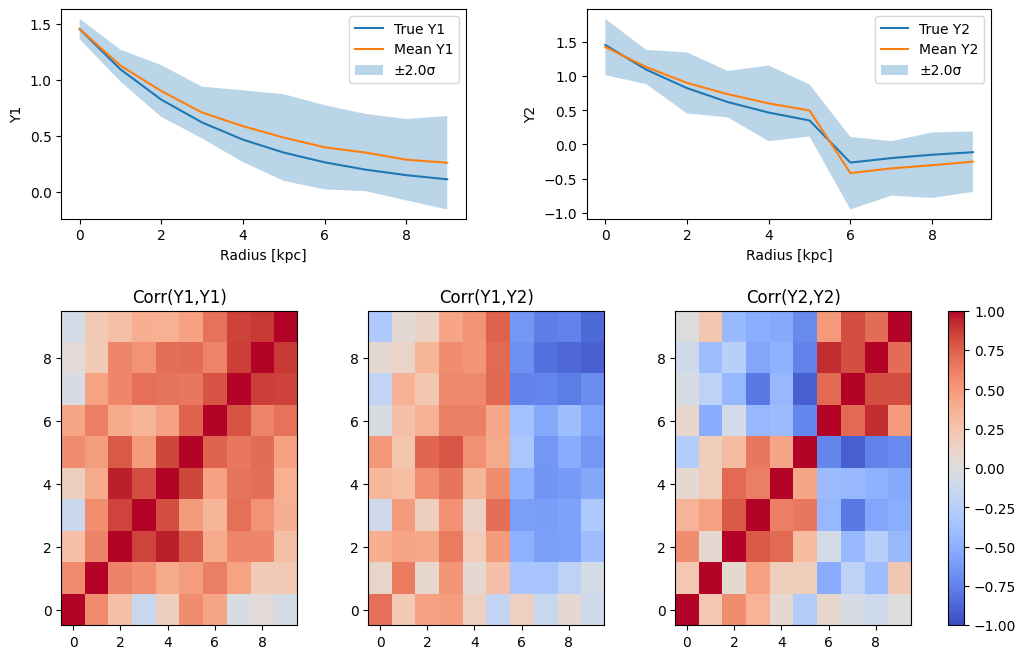

In [16]:
# select sample from test set 
idx = 0
x_sample, y_sample = test_data[idx] 
r_tags = range(0,Y1_len)

# plot
plot_one_simulation_with_bands_and_corr_blocks(
    mean_net,
    cov_net,
    x=x_sample,
    y_true=y_sample,
    r_tags=r_tags,
    device=device,
    Y1_len=Y1_len,
    ci_sigma=2.0,
);
